In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set(style="whitegrid")

from api.questrade import QTClient

In [186]:
REFRESH_TOKEN = ""

In [187]:
client = QTClient(REFRESH_TOKEN)

# Show Open Positions

In [188]:
positions = pd.DataFrame(client.get_account_positions())

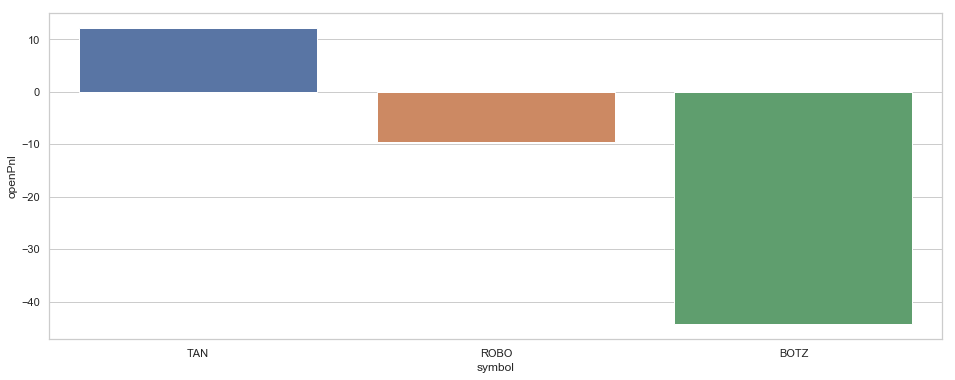

In [189]:
%matplotlib inline
plt.figure(figsize=(16, 6))
sns.barplot(x="symbol", y="openPnl", data=positions.sort_values(by=['openPnl'], ascending=False))

In [190]:
print("Open PnL: %f" % (positions['openPnl'].sum()))

Open PnL: -41.829804


# Stitch market data for all securities into one DataFrame

In [191]:
symbols = dict(zip(positions["symbolId"], positions["symbol"]))

## Add other securities to the list

In [192]:
additional_securities = [
    'BMO',
    'AAPL',
    "IBM",
    "GOOG",
    "NXJ"
]

for symbol in additional_securities:
    matched_securities = client.search(symbol)
    if len(matched_securities) > 1:
        print("%s <=> %s" %(symbol, matched_securities[0]['symbol']))
        symbols[matched_securities[0]['symbolId']] = matched_securities[0]['symbol']

BMO <=> BMO
AAPL <=> AAPL
IBM <=> IBM
GOOG <=> GOOG
NXJ <=> NXJ


In [193]:
symbols

{4807280: 'ROBO',
 21806477: 'TAN',
 15029143: 'BOTZ',
 9292: 'BMO',
 8049: 'AAPL',
 23364: 'IBM',
 11419765: 'GOOG',
 29845: 'NXJ'}

In [194]:
FROM_DATE = '2016-10-01T00:00:00-05:00'
TO_DATE = '2019-10-20T23:59:59-05:00'

historicals = pd.DataFrame()
for symbolId, symbol in symbols.items():
    candles = pd.DataFrame(client.get_candles(symbolId, FROM_DATE, TO_DATE, 'OneDay'))
    candles['end'] =  pd.to_datetime(candles['end'], format='%Y-%m-%d')
    candles['symbol'] = symbol
    candles['symbolId'] = symbol_id
    historicals = historicals.append(candles)
historicals = historicals.set_index(["symbol", "end"])

In [195]:
historicals.groupby(level="symbol")['close'].nth(5)

symbol
AAPL    116.050
BMO      63.650
BOTZ     15.422
GOOG    785.940
IBM     157.020
NXJ      14.660
ROBO     28.220
TAN      20.520
Name: close, dtype: float64

# Plot historical data

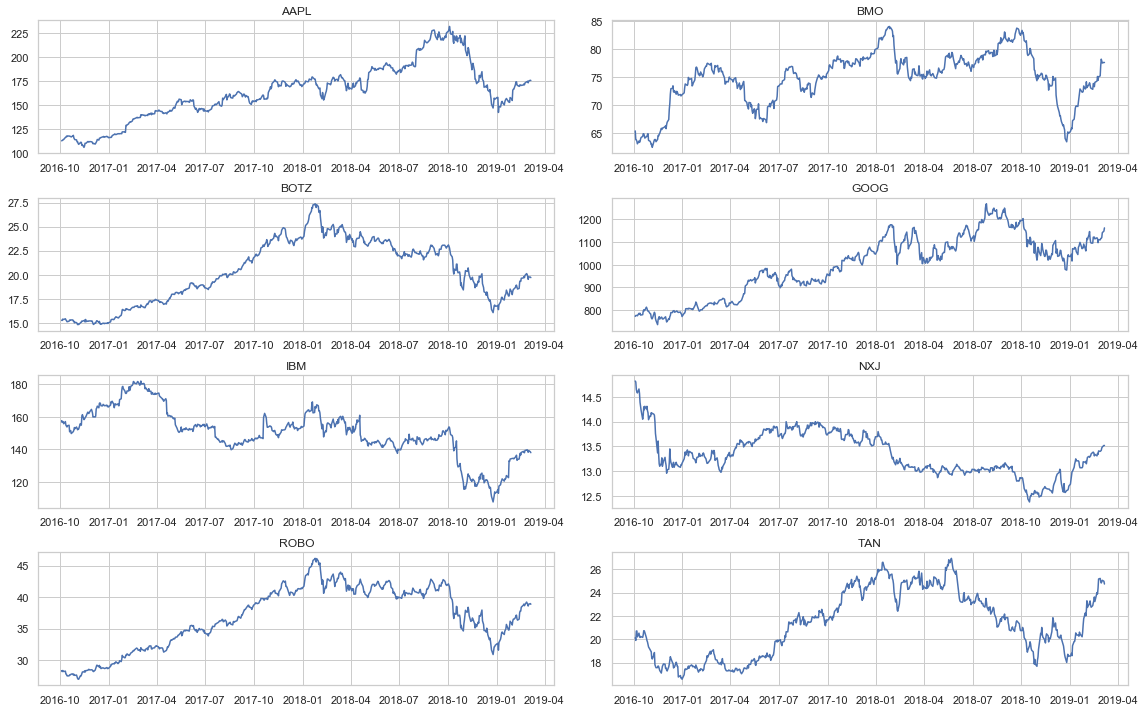

In [196]:
grouped = historicals.reset_index().set_index("end").groupby('symbol')
rows = math.ceil(grouped.ngroups / 2)                    
fig, axs = plt.subplots(figsize=(16,10), nrows=rows, ncols=2)

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.plot(grouped.get_group(key)['close'])
    ax.set_title(key)

plt.tight_layout()
plt.show()

In [197]:
historicals['daily_returns'] = historicals.groupby(level='symbol')['close'].apply(lambda x: x.pct_change())
historicals['total_returns'] = historicals.groupby(level='symbol')['daily_returns'].apply(lambda x:                                                                                        (1 + x).cumprod() - 1)

symbol
AAPL    AxesSubplot(0.125,0.2;0.775x0.68)
BMO     AxesSubplot(0.125,0.2;0.775x0.68)
BOTZ    AxesSubplot(0.125,0.2;0.775x0.68)
GOOG    AxesSubplot(0.125,0.2;0.775x0.68)
IBM     AxesSubplot(0.125,0.2;0.775x0.68)
NXJ     AxesSubplot(0.125,0.2;0.775x0.68)
ROBO    AxesSubplot(0.125,0.2;0.775x0.68)
TAN     AxesSubplot(0.125,0.2;0.775x0.68)
Name: total_returns, dtype: object

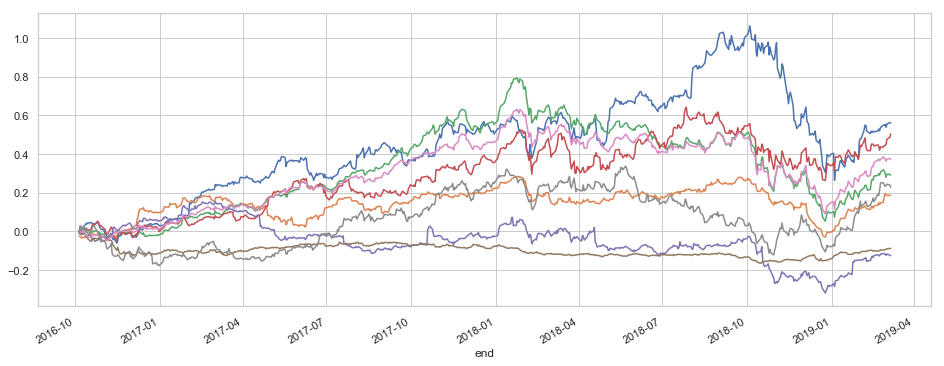

In [198]:
plt.figure(figsize=(16, 6))
historicals.reset_index().set_index("end").groupby('symbol')['total_returns'].plot()

In [199]:
historicals.groupby(level="symbol")["total_returns"].nth(-1)

symbol
AAPL    0.559989
BMO     0.186707
BOTZ    0.291236
GOOG    0.504129
IBM    -0.125182
NXJ    -0.087719
ROBO    0.373862
TAN     0.228515
Name: total_returns, dtype: float64

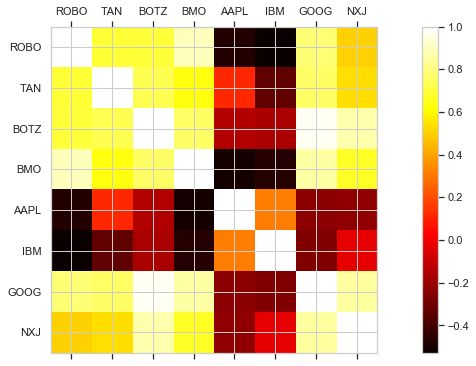

In [200]:
price_corr = historicals.reset_index().pivot('end','symbol')['close'].corr()

alpha = list(symbols.values())

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
cax = ax.matshow(price_corr, cmap='hot')
fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

plt.show()

In [201]:
price_corr

symbol,AAPL,BMO,BOTZ,GOOG,IBM,NXJ,ROBO,TAN
symbol,,,,,,,,
AAPL,1.000000,0.690659,0.698016,0.895974,-0.471197,-0.528028,0.786364,0.507815
BMO,0.690659,1.000000,0.734023,0.635850,0.119721,-0.328731,0.764319,0.538717
BOTZ,0.698016,0.734023,1.000000,0.761951,-0.143714,-0.159261,0.979851,0.870188
GOOG,0.895974,0.635850,0.761951,1.000000,-0.503718,-0.462902,0.857009,0.668452
IBM,-0.471197,0.119721,-0.143714,-0.503718,1.000000,0.315350,-0.232719,-0.218331
NXJ,-0.528028,-0.328731,-0.159261,-0.462902,0.315350,1.000000,-0.255437,-0.025794
ROBO,0.786364,0.764319,0.979851,0.857009,-0.232719,-0.255437,1.000000,0.855278
TAN,0.507815,0.538717,0.870188,0.668452,-0.218331,-0.025794,0.855278,1.000000
